# TREINAMENTO REDE EFFICIENTNET v3.2c.30e.1C

**Rede:** Efficient Net

**Dataset:** Cleaned Completo

> Epochs = 30

> Batch = 32

> Target = (100, 100)

> SEED = 10

> CLUSTERIZAÇÃO? Não

**Obs.:** Com separação de indivíduo

In [1]:
!nvidia-smi

Tue Sep  3 03:32:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_DISABLE_JIT'] = '1'

In [3]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

[I 03:32:09.884 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found
[I 03:32:09.964 NotebookApp] Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 03:32:10.316 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 03:32:10.709 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyr

## Bibliotecas e Constantes

In [4]:
!pip install tensorflow[and-cuda]

  Preparing metadata (setup.py) ... - \ done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 8.0 MB/s eta 0:00:

In [5]:
!pip install efficientnet

!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 829.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 729.8 kB/s eta 0:00:00


In [6]:
#------------------------------------------------------------------------------
# BIBLIOTECAS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING
import datetime
import tensorflow as tf
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

from efficientnet.tfkeras import EfficientNetB7

#------------------------------------------------------------------------------
# CONSTANTES

DATASET_TYPE = ['cleaned', 'selected', 'selected-localized']
DATASET_TYPE = DATASET_TYPE[1] # Dataset utilizado no treinamento

DATASET_COMPLETO = True

CNN_MODEL = 'efficient-net' # Rede utilizada no treinamento

SEED = 10
np.random.seed(SEED) # semente geradora dos numeros aleatorios
random.seed(SEED)
tf.random.set_seed(SEED)

N_FOLDS = 5
N_EPOCHS = 30
BATCH_SIZE = 32
SIZE = 100
TARGET_SIZE = (SIZE, SIZE)

VERSION = '2.2c.30e.1l'

2024-09-03 03:35:07.648719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 03:35:07.670872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 03:35:07.683531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Diretórios e Carregamentos de Dados

In [7]:
# Criando pasta de resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')

In [8]:
#------------------------------------------------------------------------------
# DIRETÓRIOS DOS DATASETS

DATASET_PATH = f'/kaggle/input/myocardits-dataset-selected/{SIZE}/'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_PATH = DATASET_PATH + '/Normal/'
SICK_PATH = DATASET_PATH + '/Sick/'

# Diretorios de cada Individuo:
normal_datasets = [f'{NORMAL_PATH}Individuo_{i:02}/' for i in range(1, 17)]
sick_datasets = [f'{SICK_PATH}Individuo_{i:02}/' for i in range(17, 48)]

print(normal_datasets)
print(sick_datasets)

NORMAL_SPLITS = [[9, 10, 12, 15],
                 [1,8,11],
                 [4,5,14],
                 [2,7,13],
                 [3,6,16]]

if DATASET_COMPLETO == True:
    SICK_SPLITS = [[21,23,26,27,36,38],
                   [18,37,39,40,41,45,46],
                   [20,24,28,29,31,32],
                   [19,22,30,33,42,47],
                   [17,25,34,35,43,44]]

normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_FOLDS):
    normal_splits[split].extend(normal_datasets[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_datasets[i-17] for i in SICK_SPLITS[split])

['/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_01/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_02/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_03/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_04/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_05/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_06/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_07/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_08/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_09/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_10/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_11/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_12/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_13/', '/kaggle/input/myocardits-dataset-selected/100//Normal/Individuo_14/', '/kag

In [9]:
#------------------------------------------------------------------------------
# CARREGAMENTO DE DADOS COM SEPARAÇÃO DE INDIVIDUOS

print('\nIniciando carregamento e processamento das imagens..............!')

def carregar_imagens(diretorio):
    global num_imagens
    imagens = []
    for pasta_atual, subpastas, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith(('.jpg', '.jpeg', '.png')):
                caminho = os.path.join(pasta_atual, arquivo)
                
                img = Image.open(caminho)
                img = img.resize(TARGET_SIZE)
                img = img.convert('L')
                img_array = np.array(img)
                imagens.append(img_array)
                
                num_imagens += 1
                sys.stdout.write("\rNumero de imagens carregados: %i" % num_imagens)
                sys.stdout.flush()
                
    return imagens

num_imagens = 0

print('\nPacientes normais:')
normal_groups = []
for diretorios in normal_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    normal_groups.append(imagens)

num_imagens = 0

print('\n\nPacientes doentes:')
sick_groups = []
for diretorios in sick_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    sick_groups.append(imagens)

# DATASETS SEPRADAOS EM 5 PARA VALIDAÇÃO CRUZADA    
x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_FOLDS):
    x_data[i].extend(path for path in normal_groups[i])
    y_data[i].extend([1, 0] for path in normal_groups[i])
    x_data[i].extend(path for path in sick_groups[i])
    y_data[i].extend([0, 1] for path in sick_groups[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_groups[i])} saudáveis e {len(sick_groups[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregados: 137

Pacientes doentes:
Numero de imagens carregados: 258

Numero de imagens por split:
Split 1: 81 imagens (32 saudáveis e 49 doentes).
Split 2: 84 imagens (27 saudáveis e 57 doentes).
Split 3: 76 imagens (26 saudáveis e 50 doentes).
Split 4: 77 imagens (26 saudáveis e 51 doentes).
Split 5: 77 imagens (26 saudáveis e 51 doentes).


## Treinamento

In [10]:
# Arquitetura CNN
def cnn_model(input_shape, num_classes):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [11]:
#------------------------------------------------------------------------------
# SEPARAÇÃO DE DADOS E TREINAMENTO

lst_accuracy=[]
lst_accuracy_v=[]
lst_acc=[]
lst_loss=[]
lst_reports=[]
lst_AUC=[]
lst_matrix=[]
lst_matrix_v=[]
lst_times=[]
lst_history=[]

#------------------------------------------------------------------------------
# TREINAMENTO POR FOLDS

for fold in range(N_FOLDS):

    print(f'\n\nFOLD {fold+1}:')

    #--------------------------------------------------------------------------
    # CARREGAMENTO DAS IMAGENS DE TREINAMENTO, VALIDACAO E TESTE

    print(f'\nCarregamento das imagens do fold {fold+1} para treinamento.............!')

    folds = [0, 1, 2, 3, 4]

    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    folds.remove(fold)

    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    folds.remove(folds[0])

    x_train, y_train = [], []
    for i in folds:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = np.stack([x_train] * 3, axis=-1)
    x_valid = np.stack([x_valid] * 3, axis=-1)
    x_test = np.stack([x_test] * 3, axis=-1)
    
    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')

    #--------------------------------------------------------------------------
    # ARQUITETURA E COMPILACAO

    model=cnn_model((SIZE, SIZE, 3), 2)
    
    OPTIMIZER = AdamW(weight_decay = 0.004)
    
    # Compilacao do modelo
    model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['categorical_accuracy'])

    #--------------------------------------------------------------------------
    # TREINAMENTO
    print('\nIniciando o treinamento.........................................!\n')

    calback=CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    # Treinando o modelo
    start=datetime.datetime.now()

    history=model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_valid, y_valid), callbacks=[calback])

    end=datetime.datetime.now()
    training_time=end-start

    # Salvamento do modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.h5')

    #--------------------------------------------------------------------------
    # TESTE

    # Testando o modelo
    print("\nTestando imagens................................................!\n")

    # Acuracia e Perda do Teste
    test_loss, test_acc = model.evaluate(x_test, y_test)

    print(model.metrics_names)

    #--------------------------------------------------------------------------
    # ARMAZENAMENTO DOS INFORMACOES

    # Fazendo previsões
    predicts = model.predict(x_test)
    predicts = predicts.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals=y_test.argmax(axis=1)

    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(actuals, predicts, pos_label=1)
    a = auc(fpr, tpr)

    # Gerando o relatório de classificação
    r = classification_report(actuals, predicts, zero_division=1)

    # Calculando a matriz de confusão
    c = confusion_matrix(actuals, predicts)
    accuracy = np.trace(c)/np.sum(c)
    
    # Validação
    # Fazendo previsões
    predicts_v = model.predict(x_valid)
    predicts_v = predicts_v.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_v=y_valid.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_v = confusion_matrix(actuals, predicts)
    accuracy_v = np.trace(c)/np.sum(c)

    lst_history.append(history)
    lst_times.append(training_time)
    lst_accuracy.append(accuracy)
    lst_acc.append(test_acc)
    lst_loss.append(test_loss)
    lst_AUC.append(a)
    lst_reports.append(r)
    lst_matrix.append(c)
    
    lst_accuracy_v.append(accuracy_v)
    lst_matrix_v.append(c_v)



FOLD 1:

Carregamento das imagens do fold 1 para treinamento.............!
Numero de imagens no treinamento: 230 imagens.
Numero de imagens na validação: 84 imagens.
Numero de imagens no teste: 81 imagens.


I0000 00:00:1725334520.668882      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725334520.669309      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725334520.851867      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725334520.852335      24 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 67,883,262 (258.95 MB)

 Non-trainable params: 310,720 (1.19 MB)


Iniciando o treinamento.........................................!

Epoch 1/30


I0000 00:00:1725334651.577782     136 service.cc:146] XLA service 0x7a4b80003d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725334651.577830     136 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725334651.577834     136 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
E0000 00:00:1725334693.948502     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725334694.086731     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725334694.394322     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - categorical_accuracy: 0.5753 - loss: 2.4899

E0000 00:00:1725334810.246294     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725334810.383420     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725334810.779258     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725334810.924938     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725334811.070935     136 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

8/8 ━━━━━━━━━━━━━━━━━━━━ 389s 21s/step - categorical_accuracy: 0.5692 - loss: 2.7371 - val_categorical_accuracy: 0.5238 - val_loss: 0.7694
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - categorical_accuracy: 0.6186 - loss: 3.2043 - val_categorical_accuracy: 0.6310 - val_loss: 0.7311
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - categorical_accuracy: 0.6536 - loss: 2.8100 - val_categorical_accuracy: 0.6786 - val_loss: 0.7447
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - categorical_accuracy: 0.7002 - loss: 1.5819 - val_categorical_accuracy: 0.5714 - val_loss: 1.6395
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - categorical_accuracy: 0.5593 - loss: 2.0671 - val_categorical_accuracy: 0.5476 - val_loss: 3.0979
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - categorical_accuracy: 0.7100 - loss: 0.8816 - val_categorical_accuracy: 0.4762 - val_loss: 8.2041
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - categorical_accuracy: 0.6862 - loss: 0.6621 - val_categoric

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 67,883,262 (258.95 MB)

 Non-trainable params: 310,720 (1.19 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 341s 17s/step - categorical_accuracy: 0.6063 - loss: 2.1132 - val_categorical_accuracy: 0.6049 - val_loss: 6.3286
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - categorical_accuracy: 0.6071 - loss: 2.9229 - val_categorical_accuracy: 0.5802 - val_loss: 1.1993
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - categorical_accuracy: 0.6453 - loss: 1.3422 - val_categorical_accuracy: 0.6049 - val_loss: 4.7327
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - categorical_accuracy: 0.6944 - loss: 1.2995 - val_categorical_accuracy: 0.5556 - val_loss: 0.9987
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - categorical_accuracy: 0.7007 - loss: 1.0042 - val_categorical_accuracy: 0.4568 - val_loss: 1.8594
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - categorical_accuracy: 0.6288 - loss: 1.0956 - val_categorical_accuracy: 0.4444 - val_loss: 2.7737
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 67,883,262 (258.95 MB)

 Non-trainable params: 310,720 (1.19 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - categorical_accuracy: 0.6133 - loss: 1.6401

E0000 00:00:1725335743.204865     137 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725335743.342320     137 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725335743.639665     137 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725335743.784600     137 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725335744.617738     137 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

8/8 ━━━━━━━━━━━━━━━━━━━━ 365s 21s/step - categorical_accuracy: 0.6124 - loss: 1.7661 - val_categorical_accuracy: 0.4074 - val_loss: 1.2322
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - categorical_accuracy: 0.6868 - loss: 1.9880 - val_categorical_accuracy: 0.6049 - val_loss: 4.0070
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - categorical_accuracy: 0.6293 - loss: 2.7599 - val_categorical_accuracy: 0.6049 - val_loss: 3.1993
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - categorical_accuracy: 0.6954 - loss: 0.7456 - val_categorical_accuracy: 0.5556 - val_loss: 2.7508
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - categorical_accuracy: 0.7290 - loss: 1.2558 - val_categorical_accuracy: 0.5802 - val_loss: 1.6114
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - categorical_accuracy: 0.7218 - loss: 1.3110 - val_categorical_accuracy: 0.4815 - val_loss: 1.6288
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - categorical_accuracy: 0.6852 - loss: 0.7143 - val_categoric

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 67,883,262 (258.95 MB)

 Non-trainable params: 310,720 (1.19 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - categorical_accuracy: 0.5315 - loss: 3.2763

E0000 00:00:1725336229.094005     135 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725336229.231469     135 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725336229.588691     135 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725336229.733606     135 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725336229.878770     135 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

8/8 ━━━━━━━━━━━━━━━━━━━━ 371s 21s/step - categorical_accuracy: 0.5334 - loss: 3.4115 - val_categorical_accuracy: 0.6049 - val_loss: 4.4911
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - categorical_accuracy: 0.5823 - loss: 1.5357 - val_categorical_accuracy: 0.6049 - val_loss: 4.3556
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - categorical_accuracy: 0.6248 - loss: 0.8957 - val_categorical_accuracy: 0.6049 - val_loss: 20.0077
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - categorical_accuracy: 0.5767 - loss: 1.0460 - val_categorical_accuracy: 0.6049 - val_loss: 10.3823
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - categorical_accuracy: 0.6927 - loss: 1.0807 - val_categorical_accuracy: 0.4198 - val_loss: 5.5953
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - categorical_accuracy: 0.7019 - loss: 0.8980 - val_categorical_accuracy: 0.4691 - val_loss: 2.4192
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - categorical_accuracy: 0.7122 - loss: 0.9487 - val_categor

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 67,883,262 (258.95 MB)

 Non-trainable params: 310,720 (1.19 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 355s 19s/step - categorical_accuracy: 0.5130 - loss: 4.0255 - val_categorical_accuracy: 0.4815 - val_loss: 1.0503
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - categorical_accuracy: 0.4749 - loss: 3.5399 - val_categorical_accuracy: 0.6049 - val_loss: 1.3182
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - categorical_accuracy: 0.6315 - loss: 2.1883 - val_categorical_accuracy: 0.6049 - val_loss: 3.2731
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - categorical_accuracy: 0.6383 - loss: 1.0004 - val_categorical_accuracy: 0.6049 - val_loss: 6.3939
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - categorical_accuracy: 0.6811 - loss: 4.0662 - val_categorical_accuracy: 0.6296 - val_loss: 1.7235
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - categorical_accuracy: 0.6981 - loss: 0.6299 - val_categorical_accuracy: 0.6049 - val_loss: 0.8837
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━

In [12]:
'''from matplotlib import cm
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

def visualize_gradcam(model, img_array, image_title):
    # Ensure the input image array has the correct shape and type
    img_array = np.expand_dims(img_array, axis=-1)  # Ensure it has a single channel if needed
    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension if needed
    img_array = img_array.astype(np.float32)        # Convert to float32 if needed

    # Create Gradcam object
    gradcam = Gradcam(model,
                      model_modifier=None,  # Modify if needed
                      clone=True)

    # Define a função de pontuação (score function)
    def score_function(output):
        return output[:, np.argmax(output[0])]  # Use o índice da classe com maior probabilidade

    # Generate heatmap with GradCAM
    cam = gradcam(score=score_function,
                  penultimate_layer=-1,  # Index of the penultimate layer
                  seed_input=img_array)

    # Process the heatmap for visualization
    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)  # Apply colormap and convert to uint8
    heatmap = np.squeeze(heatmap)  # Remove single-dimensional entries from the shape of an array

    # Render
    plt.figure(figsize=(6, 4))
    plt.title(image_title, fontsize=16)
    plt.imshow(img_array[0, :, :, 0], cmap='gray', alpha=0.5)  # Show the grayscale image
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Carregar o modelo treinado
model = load_model(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.h5')

# Imagens de teste
imgs_array = []

caminhos = ['/kaggle/input/myocardits-dataset-cleaned/224/Sick/Individuo_18/series0005-Body/img0013-40.5666.jpg',
            '/kaggle/input/myocardits-dataset-cleaned/224/Normal/Individuo_10/series0001-Body/img0001--9.jpg',
            '/kaggle/input/myocardits-dataset-cleaned/224/Normal/Individuo_01/series0003-Body/img0001--43.937.jpg',
            '/kaggle/input/myocardits-dataset-cleaned/224/Sick/Individuo_35/series0006-Body/img0011-44.8372.jpg']
for caminho in caminhos:
    img = Image.open(caminho)  # Carrega a imagem
    img = img.resize(TARGET_SIZE)  # Redimensiona para 100x100
    img_array = np.array(img)  # Converte para array NumPy
    rgb_array = np.tile(img_array[:, :, np.newaxis], (1, 1, 3))
    imgs_array.append(rgb_array)

for img_array in imgs_array:
    image_title = 'Mapa de Calor'

    # Visualizar com GRAD-CAM
    visualize_gradcam(model, img_array, image_title)'''


"from matplotlib import cm\nfrom tensorflow.keras.models import load_model\nfrom tf_keras_vis.gradcam import Gradcam\nfrom tf_keras_vis.utils import normalize\n\ndef visualize_gradcam(model, img_array, image_title):\n    # Ensure the input image array has the correct shape and type\n    img_array = np.expand_dims(img_array, axis=-1)  # Ensure it has a single channel if needed\n    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension if needed\n    img_array = img_array.astype(np.float32)        # Convert to float32 if needed\n\n    # Create Gradcam object\n    gradcam = Gradcam(model,\n                      model_modifier=None,  # Modify if needed\n                      clone=True)\n\n    # Define a função de pontuação (score function)\n    def score_function(output):\n        return output[:, np.argmax(output[0])]  # Use o índice da classe com maior probabilidade\n\n    # Generate heatmap with GradCAM\n    cam = gradcam(score=score_function,\n                  penulti

## Salvamento de Dados

In [13]:
#--------------------------------------------------------------------------
# SALVAMENTO DOS DADOS

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
matrix_total = np.sum(lst_matrix, axis=0)
accuracy_total = np.trace(matrix_total)/np.sum(matrix_total)

matrix_total_v = np.sum(lst_matrix_v, axis=0)
accuracy_total_v = np.trace(matrix_total_v)/np.sum(matrix_total_v)
    
losses=[]
val_losses=[]
accuracies=[]
val_accuracies=[]

for item in lst_history:
    
    history=item.history
    loss=history['loss']
    accuracy=history['categorical_accuracy']
    
    val_loss=history['val_loss']
    val_accuracy=history['val_categorical_accuracy']
    
    losses.append(sum(loss)/len(loss))
    accuracies.append(sum(accuracy)/len(accuracy))
    
    val_losses.append(sum(val_loss)/len(val_loss))
    val_accuracies.append(sum(val_accuracy)/len(val_accuracy))

f1=open(path,'w')
f1.write(f'TREINAMENTO v{VERSION}\n')

f1.write('\nTest Accuracias: '+str(lst_acc)+'\nTest Losses: '+str(lst_loss))
f1.write('\n\nTest Accuracies Mean: '+str(np.mean(lst_acc)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nValid Accuracies: '+str(val_accuracies)+'\nValid Losses: '+str(val_losses))
f1.write('\n\nValid Accuracies Mean: '+str(np.mean(val_accuracies)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\nAccuracies from Confusion Matrix: '+str(lst_accuracy))

f1.write('\n\nTotal Confusion Matrix: \n'+str(matrix_total)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix: '+str(accuracy_total))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Valid: \n'+str(matrix_total_v)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Valid: '+str(accuracy_total_v))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nMetrics for all Folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_AUC[i]))
    f1.write('\n\nAcurácia: ' + str(lst_accuracy[i]))
    f1.write('\n\nMatriz de Confusao: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
f1.close()


Salvando informações da rede......................................!


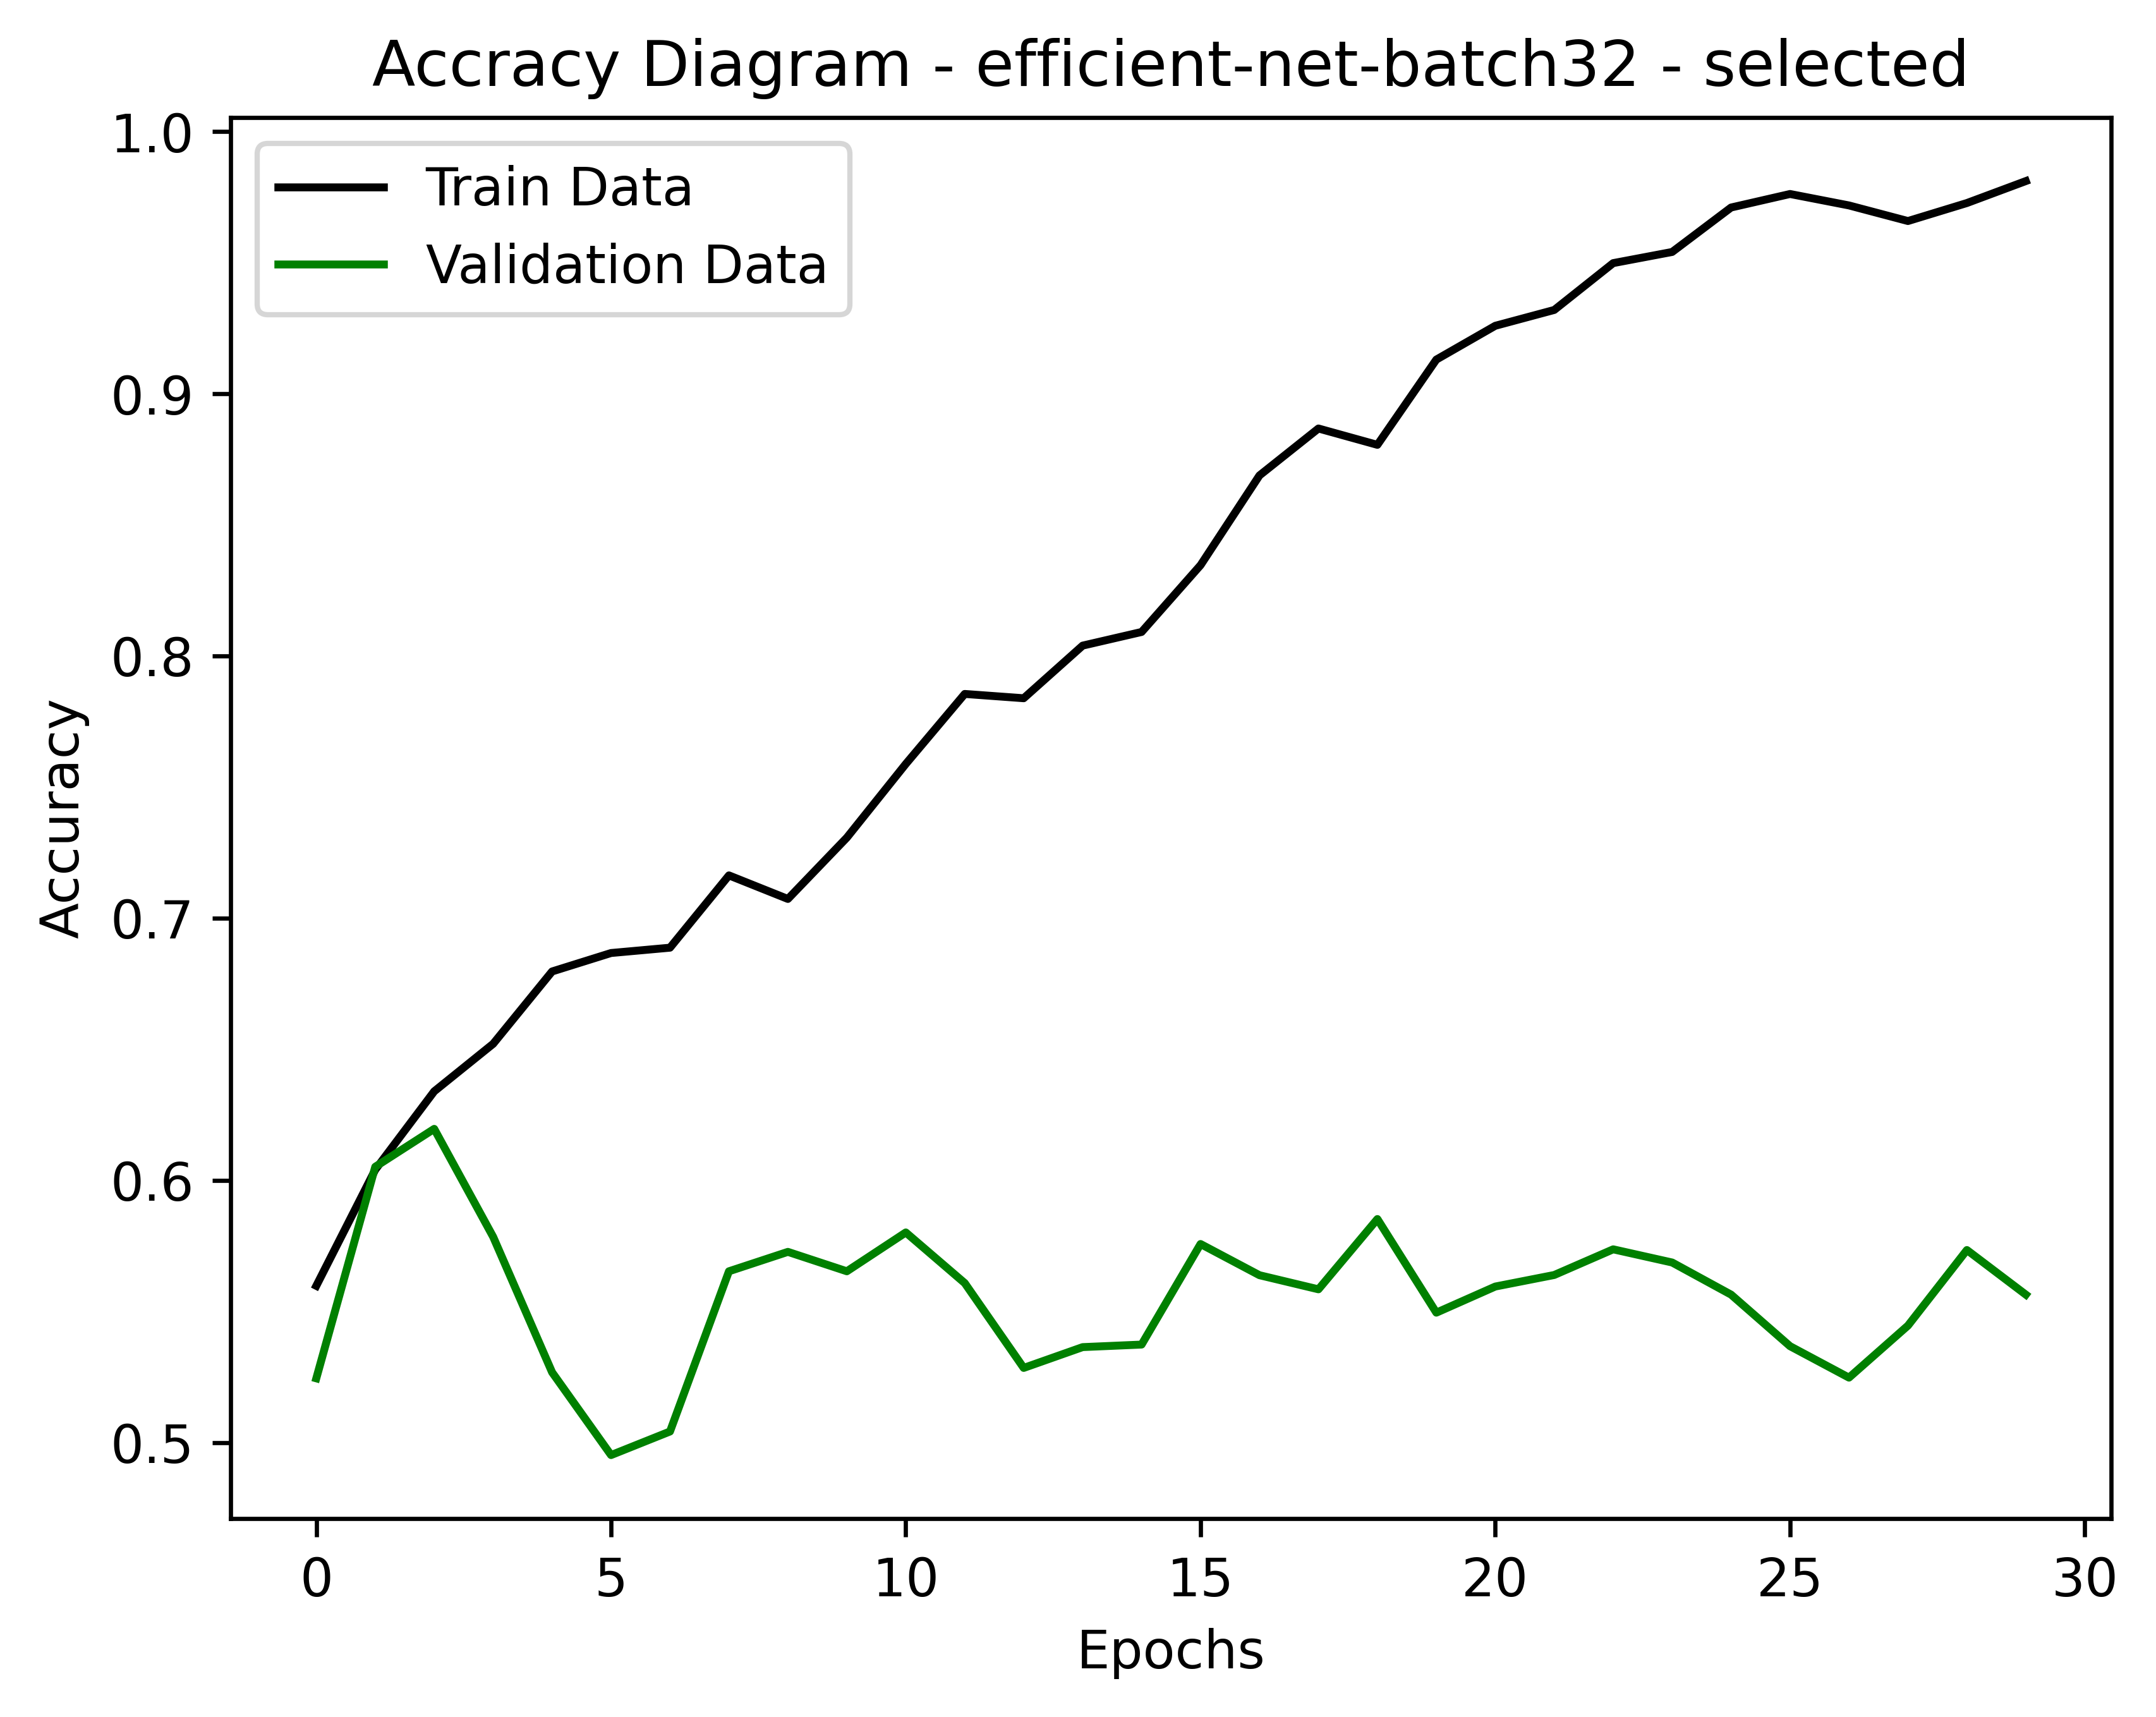

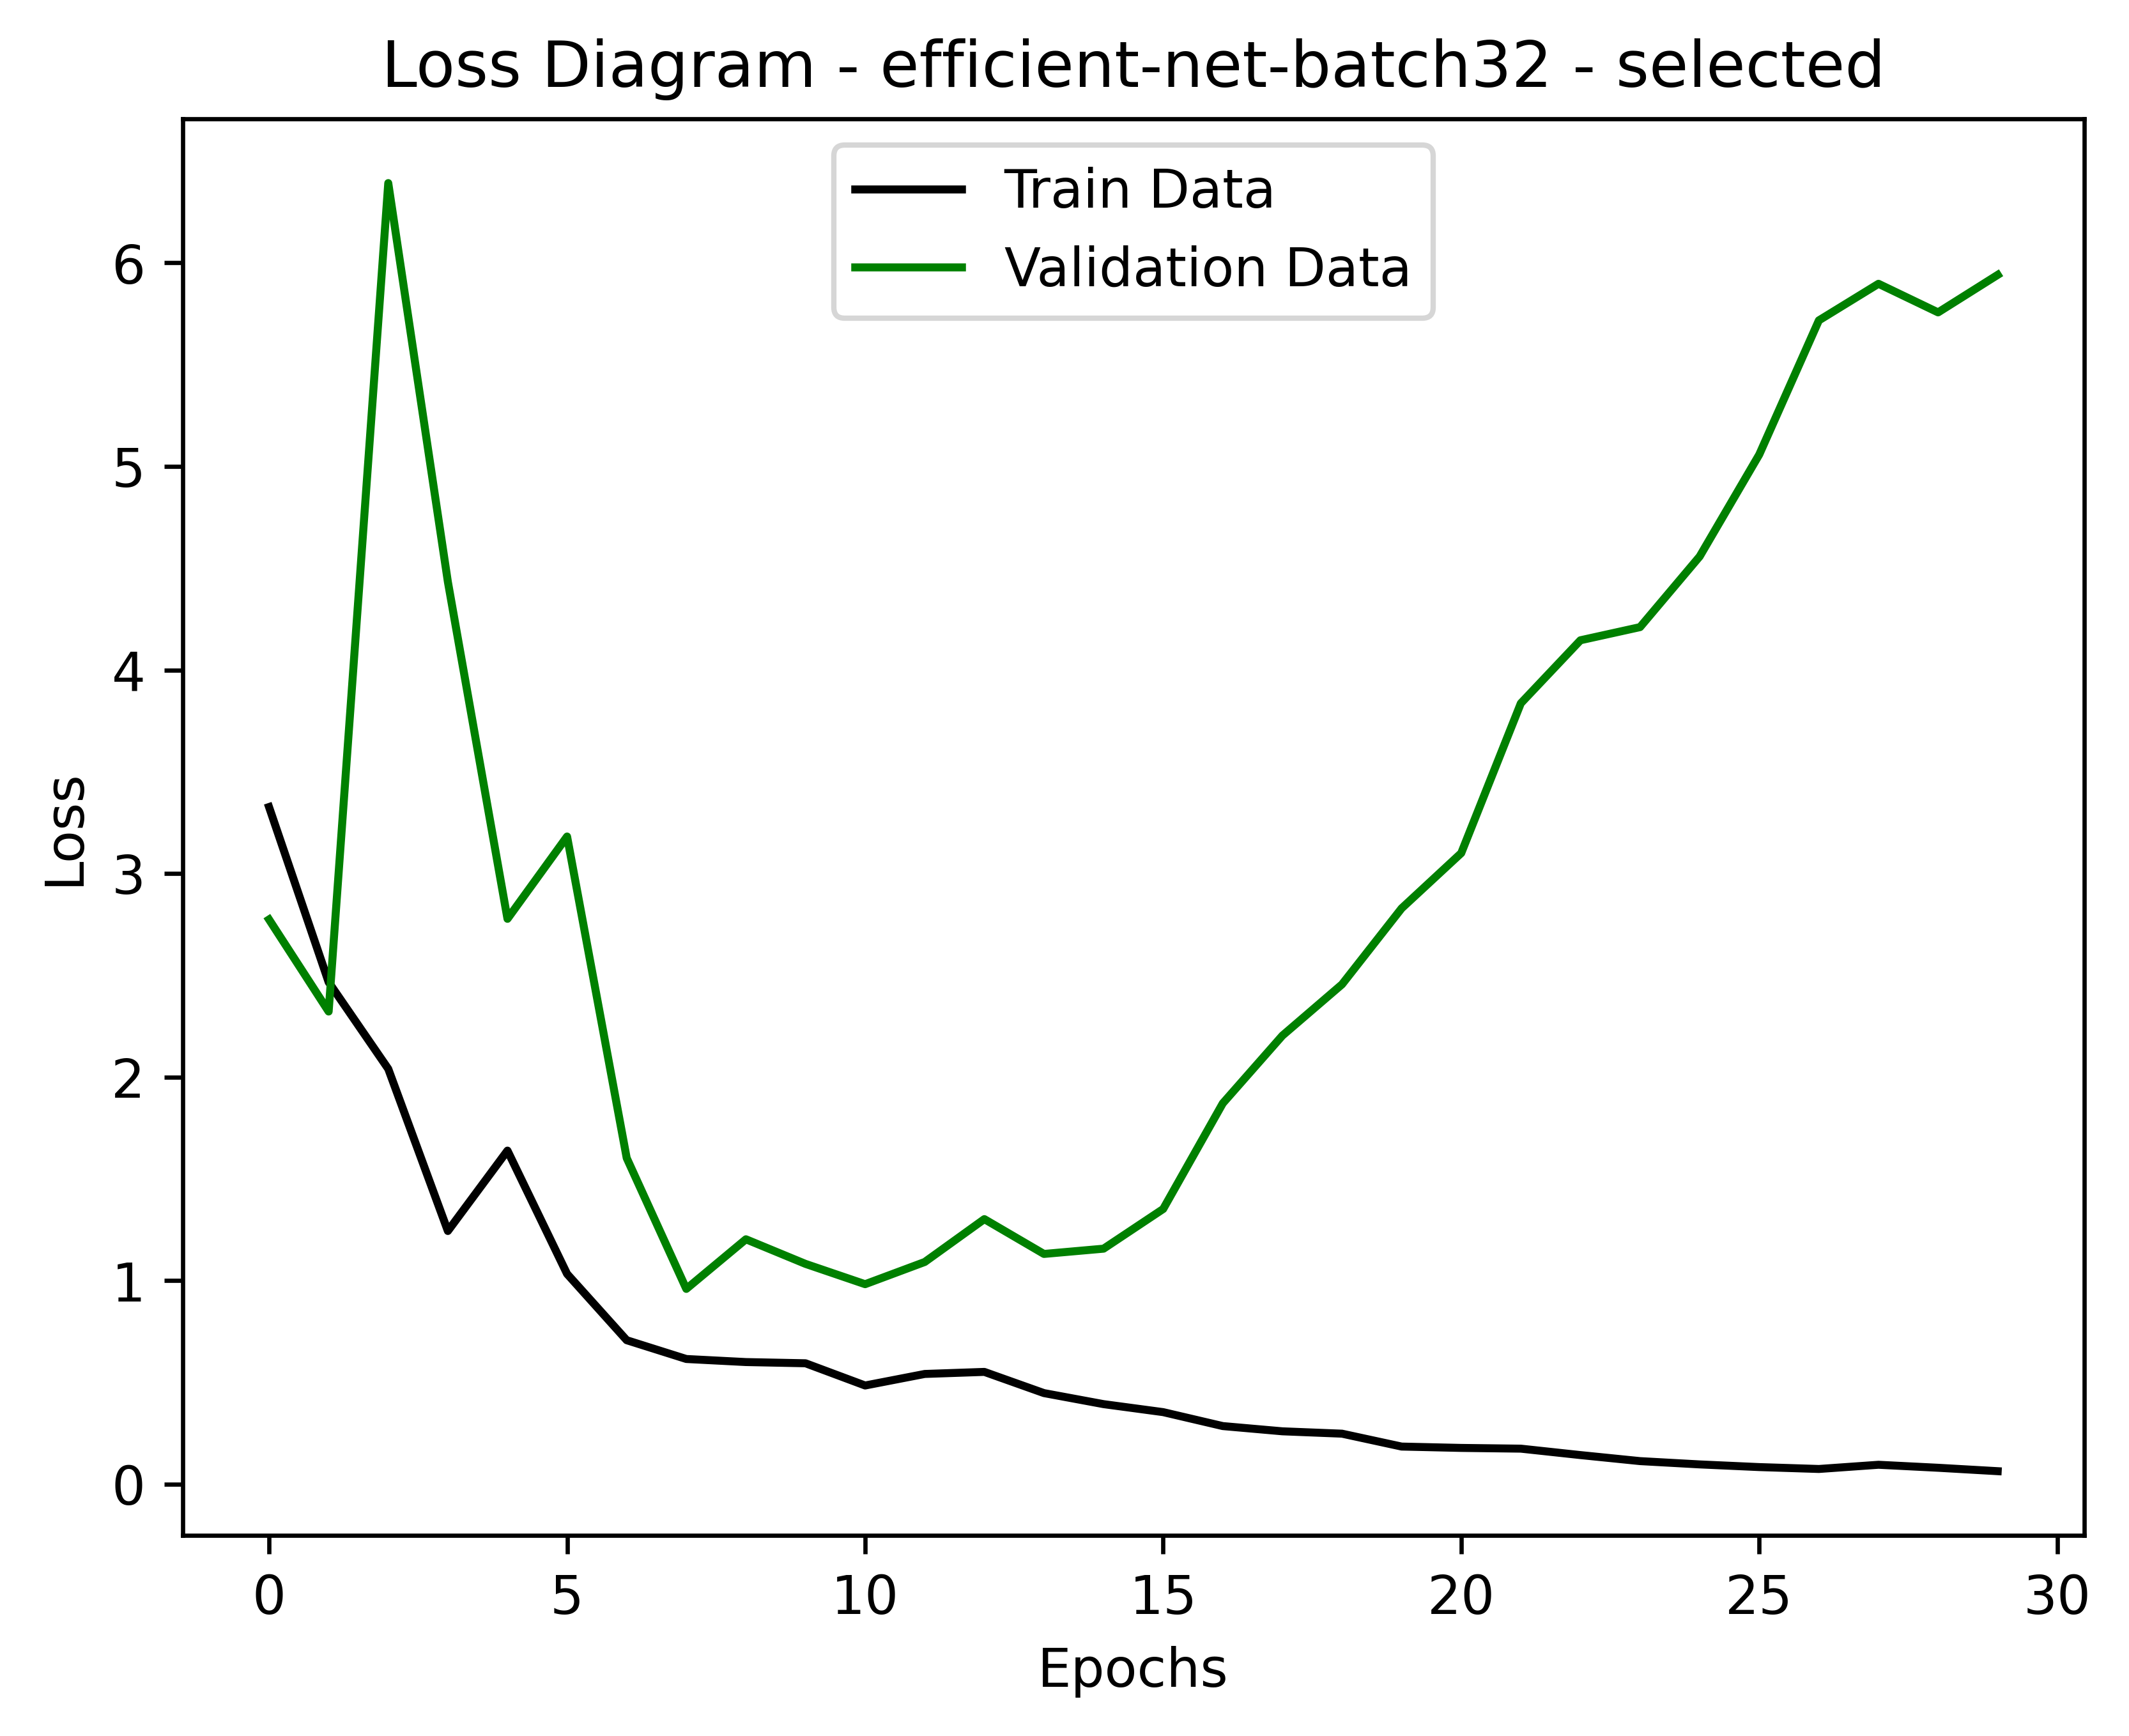

In [14]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['categorical_accuracy']
        val_accuracy=history['val_categorical_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i
        
    N_SPLITS = 5

    # 10 is number of folds
    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()
    
    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accracy Diagram',dpi=600)
    plt.title(f'Accracy Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')
    
NetPlot(lst_history,N_EPOCHS)

In [15]:
# Zipando pasta com resultados
import zipfile

def compactar_pasta(pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, _, files in os.walk(pasta):
            for arquivo in files:
                caminho_completo = os.path.join(root, arquivo)
                zip_file.write(caminho_completo, os.path.relpath(caminho_completo, pasta))

nome_arquivo_zip = f'{VERSION}-results.zip'
compactar_pasta(RESULTS_PATH, nome_arquivo_zip)